In [1]:
import sys
print(sys.executable)

!{sys.executable} -m pip install sklearn

/bin/python3


In [2]:
! pip install scipy
! python --version

Python 3.9.1


In [3]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

## <center> Introduction </center>

In this tutorial we work on breast histology images. Our goal is to classify Invasive Ductal Carcinoma (IDC) images vs non IDC images using a standard data science pipeline : 
- Explore your dataset
- Define your objective and a metric
- Set a baseline algorithm : features / model / parameter optimization
- Improve it
    


The dataset has been curated from [Andrew Janowczyk website](http://www.andrewjanowczyk.com/use-case-6-invasive-ductal-carcinoma-idc-segmentation/)

# <center> 1. Get your data </center>

The first step is simply to get your data ! Data can have any modality : csv file, dicom image, text file, mp3 record... 

Then, using your favorite programming language (mainly python or R!) and appopriated packages (pandas, numpy...) you can read your data.

In [4]:
# I did the work for you ! 
X = np.load('X.npy') # images
Y = np.load('Y.npy') # labels associated to images (0 = no cancer, 1 = cancer)

In [6]:
X.shape

(5547, 50, 50, 3)

# <center> 2. Explore the dataset  </center>

Let's explore your dataset now ! It is fundamental to become familiar with your data, especially if you're not an expert. This step includes :
- Checking data issues of any sort : missing values, outliers, unreadable files etc.
- Searching **bias in the dataset**. For instance imagine you have to predict the age of a patient based on is height, weight and other values... and you didn't see that birth of date was in these values : your algorithm is going to learn a completly dumb thing.
- Plot histograms, correlations, use standard data analysis techniques sur as PCA
- Try to evaluate the difficulty of the task you want to perform
- And of course, have a look to related works on this dataset ! Maybe someone did the work for you :)

In [ ]:
# How many images ?

print('Total number of images : {}'.format(len(X)))
print('Number of images without cancer : {}'.format(np.sum(Y==0)))
print('Number of images with cancer : {}'.format(np.sum(Y==1)))
print('Percentage of positive images : {:.2f}%'.format(100*np.mean(Y)))

# What is the size of the images ?

print('Image shape (number of rows, number of columns, channels RGB): {}'.format(X[0].shape))

Total number of images : 5547
Number of images without cancer : 2759
Number of images with cancer : 2788
Percentage of positive images : 50.26%
Image shape (number of rows, number of columns, channels RGB): (50, 50, 3)


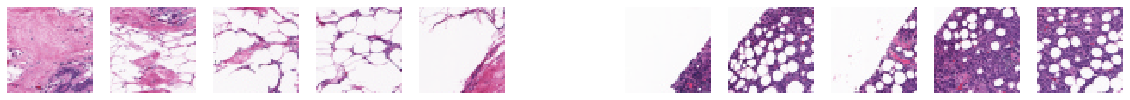

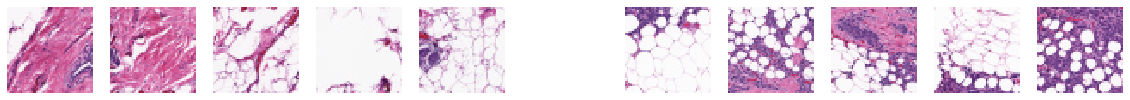

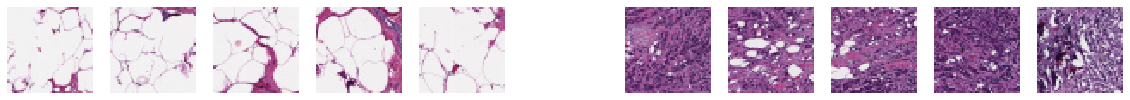

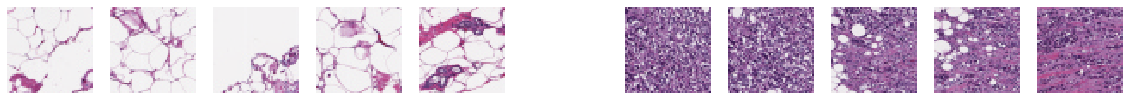

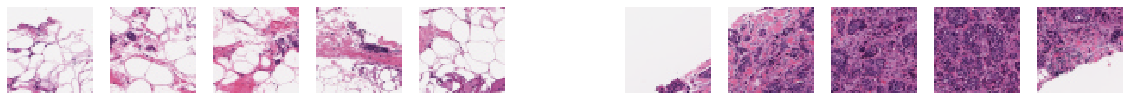

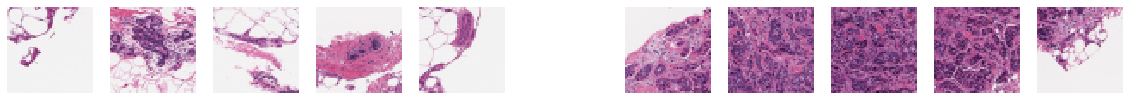

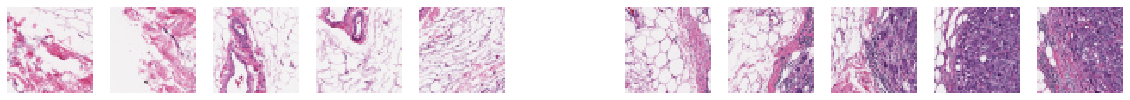

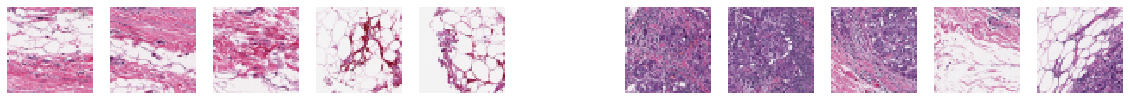

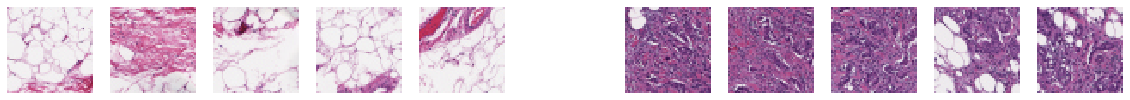

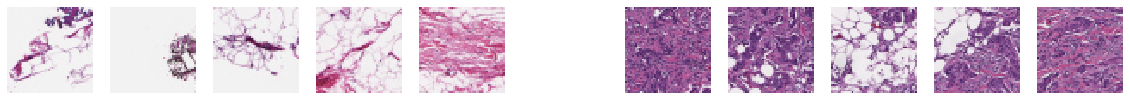

In [ ]:
# Looking at some images

imgs0 = X[Y==0] # images with label 0 = no cancer, negative image
imgs1 = X[Y==1] # images with label 1 =    cancer, positive image

batch = 0 # Each batch plot 50 negative images on the left and 50 positive images on the right

for row in range(10):
    plt.figure(figsize=(20, 10))
    for col in range(5):
        plt.subplot(1,11,col+1)
        plt.imshow(imgs0[50*batch + 5*row+col])
        plt.axis('off')
        
        plt.subplot(1,11,col+7)
        plt.imshow(imgs1[50*batch + 5*row+col])
        plt.axis('off')

Here we can observe that colors are quite different between positive images and negative images. Colors could be an easy way to classify these images ! 

# <center> 3. Define your objective and metrics </center>

Now that you are familiar with your data, you have to define your objective and the way you will measure how you achieved it. The machine learning scheme is quite different from the statistics scheme : we evaluate a model based on its predictive performance and not on the probability to observe the data given the model.

In our case, the objective (or task) is **binary classification** of images and our measure performance will be the **accuracy** (percentage of good classification). Note that accuracy is not always a good measure : if you have an unbalanced dataset with only 1% of positive examples, predicting always 0 (negative) will lead to a 99% accuracy !

The measure is often called **metric or loss**. It depends on what you want, interested by the trade off precision recall ? use F1 score. Interested by the trade-off true positive detection / false positive detection ? Use ROC-AUC. 

To measure the predictive performance using our metric, we will use **cross validation**. The idea is to split the dataset into 2 groups : the training set that we will use to calibrate the parameters of a model, and the test set that we will use to evaluate the performance of the model using our metric. 

In cross validation, we split the dataset multiple times (ex 80/20 or 90/10), and average the performances on the diffrent test sets. A common technique is to partition the dataset into N equal parts, called **folds**,  and to split N times the dataset such that each part will be once the test set. For instance if you divide your dataset into 5 folds [1,2,3,4,5] then you will split 5 times the dataset : 

- train = [2,3,4,5] test = [1] > evaluate performance on the test set to get score1
- train = [1,3,4,5] test = [2] > ... score2 
- train = [1,2,4,5] test = [3] > ... score3 
- train = [1,2,3,5] test = [4] > ... score4 
- train = [1,2,3,4] test = [5] > ... score5 
- predictive performance = (score1 + score2 + score3 +score4 +score5)/5

In [ ]:
from sklearn.model_selection import StratifiedKFold as KFold

# Prepare the folds for a cross validation. We use the very useful scikit learn package. Here we use stratified 
# cross validation : the proportion of positive and negative examples is the same in all folds

N = len(X)
folds = lambda : KFold(n_splits = 5, shuffle = True, random_state=0).split(X, Y)

# Let's have a look to the split size and 

for i, (train_indexes, test_indexes) in enumerate(folds()):
    print('split {}: training : {} images, test : {} images'.format(i + 1, len(train_indexes), len(test_indexes)))

split 1: training : 4437 images, test : 1110 images
split 2: training : 4437 images, test : 1110 images
split 3: training : 4438 images, test : 1109 images
split 4: training : 4438 images, test : 1109 images
split 5: training : 4438 images, test : 1109 images


# <center> 4. Set a baseline model  </center>

Now it's time to create our first model ! A good practice is to set a **baseline**, i.e. a very simple model. It permits to quickly have a first score to compare with when using more complex models and it also often helps a lot to organize your code and data.

A common machine learning way to create a new model is :
1. Extract features from your data. In our case we saw that colors of the images could be a good feature. Here expert knowledge is welcome ! 
2. Use a learning algorithm you think appropriate : k-nearest neighbors, linear or logistic regression, random forests, SVMs, neural networks and **XGboost** 
3. Optimize the hyper-parameters of your learning algorithm 

### <center> 4.1. Create features </center>


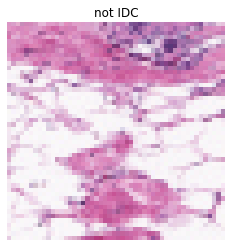

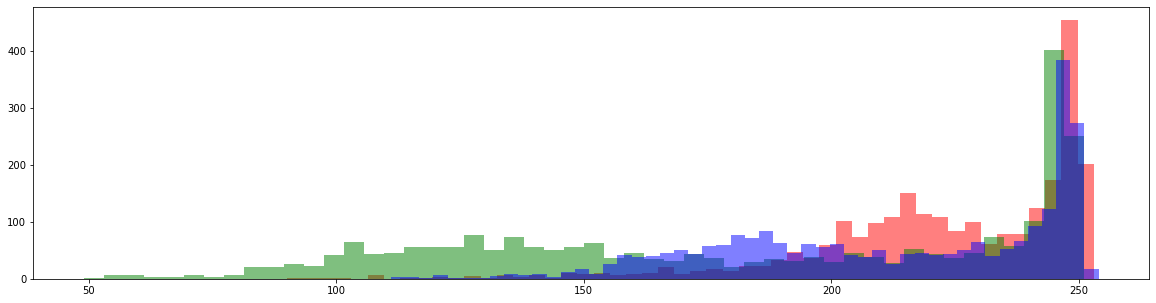

In [ ]:
# We look at RGB histograms (represent colors). Histogram counts the number of pixels with a certain intensity
# between 0 and 255 for each color red, green and blue. A peak at 255 for all colors mean a lot of white ! 

i= 1 # Try 0, 1, 2.. for negative images and -1, -2, -3 for positive images and compare the histograms.
xi = X[i]

plt.imshow(xi)
plt.axis('off')
plt.title('IDC' if Y[i] else 'not IDC')

plt.figure(figsize=(20,5))
n_bins = 50
plt.hist(xi[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.hist(xi[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
plt.hist(xi[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

In [ ]:
# Our feature will be the concatenation of the 3  histograms: red, green and blue. 

histogram_features = []
n_bins = 50 # We decide to keep 50 bins in the histogram, but you can try other values ! (up to 255)
for xi in X:
    hr = np.histogram(xi[:,:,0].flatten(), bins= n_bins)[0]
    hg = np.histogram(xi[:,:,1].flatten(), bins= n_bins)[0]
    hb = np.histogram(xi[:,:,2].flatten(), bins= n_bins)[0]
    hi = np.concatenate([hr, hg, hb])
    histogram_features.append(hi)

histogram_features = np.array(histogram_features)

print('histogram shape : ', histogram_features.shape)

histogram shape :  (5547, 150)


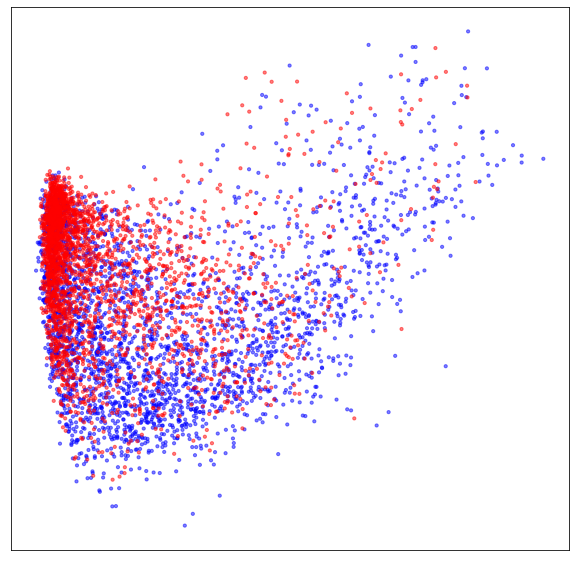

In [ ]:
# Here we visualize our features in 2D using PCA, colored by the positive (red) / negative (blue) class

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, SpectralEmbedding

model = PCA(n_components=2) # Try to replace PCA by SpectralEmbedding, TSNE !
PC = model.fit_transform(histogram_features)

plt.figure(figsize=(10,10))
plt.scatter(PC[:,0], PC[:, 1], s= 10, c=['r' if yi else 'b' for yi in Y], alpha = 0.5)
plt.xticks([]);
plt.yticks([]);

The PCA shows that our simple histogram feature already permits to linearly separate a bit positive and negative images ! Good point ! 

### <center> 4.2. Run a simple algorithm </center>

10 first predictions in probability : [0.8 1.  0.4 0.2 0.2 0.4 0.2 0.  0.4 0. ]
10 first predictions 0/1 :  [1 1 0 0 0 0 0 0 0 0]
10 first real labels     :  [0 0 0 0 0 0 0 0 0 0]
Accuracy : 73.61%
Confusion matrix (see wikipedia for more info)
[[1925  834]
 [ 630 2158]]
AUC is the probability for a positive image to have a higher score than a negative image


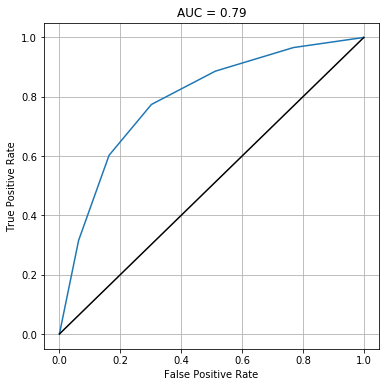

In [ ]:
# Here we will use the k nearest neighbors algorithm : given a new image, find the k (e.g. k=10) images in the training set
# with the most similar histograms. If m of these neighors (e.g m=6) have label 1, then output p = 60%.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# This function run train the model ! 
def run_model(model, features):
    Y_pred = np.zeros(Y.shape)
    # For each fold :
    for train_indexes, valid_indexes in folds():
        # Train the model on the training data
        model.fit(features[train_indexes], Y[train_indexes])
        # And predict the results on the test data
        Y_pred[valid_indexes] = model.predict_proba(features[valid_indexes])[:,1]
    # Return all the predictions (probabilities between 0 and 1)
    return Y_pred

# Here we use kNN model : 
model = KNeighborsClassifier(n_neighbors=5, n_jobs=8)
# And call the function run_model
Y_pred = run_model(model, histogram_features)

# Let's print the results
print('10 first predictions in probability : {}'.format(Y_pred[:10]))
Y_pred_01 = (Y_pred > 0.5).astype('int')
print('10 first predictions 0/1 :  {}'.format(Y_pred_01[:10]))
print('10 first real labels     :  {}'.format(Y[:10]))
print('Accuracy : {:.2f}%'.format(100 * np.mean(Y == Y_pred_01)))

print('Confusion matrix (see wikipedia for more info)')
print(confusion_matrix(Y, Y_pred_01))


plt.figure(figsize=(6,6))
fpr, tpr, _ = roc_curve(Y, Y_pred)
plt.plot(fpr, tpr)
plt.title('AUC = {:.2f}'.format(roc_auc_score(Y, Y_pred)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.plot([0,1],[0,1], 'black')
print('AUC is the probability for a positive image to have a higher score than a negative image')


### <center> 4.3. Optimize the hyper-parameters of your algorithm  </center>

accuracy = 73.61% at x = 5
accuracy = 73.91% at x = 6
accuracy = 73.90% at x = 7
accuracy = 74.36% at x = 8
accuracy = 73.91% at x = 9
accuracy = 74.33% at x = 10
accuracy = 74.20% at x = 11
accuracy = 74.92% at x = 12
accuracy = 74.42% at x = 13
accuracy = 74.91% at x = 14


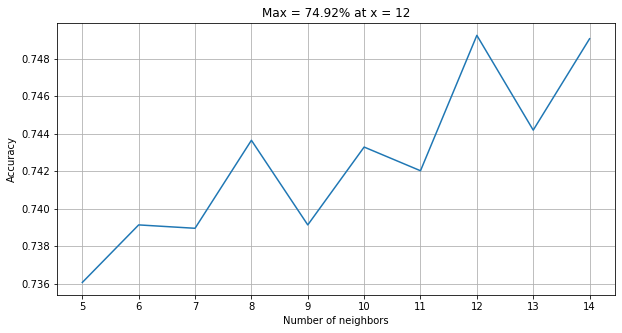

In [ ]:
# How does the accuracy evolves with the number of neighbors ?

def plot_accuracy(model, features, x_range):

    accuracy = []
    for x in x_range:
        accuracy.append(np.mean(Y == (run_model(model(x), features) > 0.5).astype('int')))
        print('accuracy = {:.2f}% at x = {}'.format(100*accuracy[-1], x))
    plt.figure(figsize=(10,5))
    plt.plot(x_range, accuracy)
    plt.xlabel('Number of neighbors')
    plt.xticks(x_range)
    plt.ylabel('Accuracy')
    plt.title('Max = {:.2f}% at x = {}'.format(100*np.max(accuracy), x_range[np.argmax(accuracy)]))
    plt.grid()
    
plot_accuracy(lambda k : KNeighborsClassifier(n_neighbors=k, n_jobs=8), histogram_features, range(5,15))

## <center> 5. Improve features and model   </center>

### <center> 5.1. Better features  </center>

In [ ]:
# Here we use features extracted from a deep neural network : we achieve much better results with the same"
# algorithm that our simple histogram features ! 

resnet_features = np.load('resnet_features.npy')
print resnet_features.shape

# Nearest Neighbors
plot_accuracy(lambda k : KNeighborsClassifier(n_neighbors=k, n_jobs=8), resnet_features, range(5,45,5))

In [ ]:
# The code to extract deep learning features : a bit long to run ! 

#from keras.applications.resnet50 import ResNet50, preprocess_input

#model = ResNet50(weights='imagenet', include_top=False, pooling='max)
#X_224 = np.array([imresize(xi, (224, 224)) for xi in X])
#X_224 = preprocess_input(X_224.astype('float'))
#resnet_features = model.predict(X_224, verbose=1)

### <center> 5.2. Better Algorithms  </center>

In [ ]:
# Logisitic Regression

from sklearn.linear_model import LogisticRegression
Y_pred_01 = (run_model(LogisticRegression(n_jobs=8), histogram_features) > 0.5).astype('int')
print 'Accuracy : {:.2f}%'.format(100* np.mean(Y == Y_pred_01))

In [ ]:
# Random Forests

from sklearn.ensemble import RandomForestClassifier
plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              histogram_features, range(5, 55, 5))

## <center> 6. Use Deep Learning   </center>

Deep learning for images is end to end : there is no need to exctract features from the image because the algorithm learns itself these features from raw data ! Neural networks are not easy to train, especially from scratch, and require a lot of data. But when possible, it shows amazing performance ! In the code below, we run quite a randomly designed neural network to see how it works. Don't expect it to have very good results ;) Also, use it as a black box as this tuto doesn't aim to explain how deep learning works ! Training a neural network can be long, so we just use 1 fold

In [ ]:
import keras # We use keras library wuth tensorflow backend
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping

# Special callback to see learning curves
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

# Preprocess the data : center and normalize
X2 = X / 255.
X2 = X2 - np.mean(X2, axis = (0,1,2))
X2 = X2 / np.std(X2, axis = (0,1,2))

# Create the model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(50, 50, 3))) # first layer : convolution
model.add(MaxPooling2D(pool_size=(3, 3))) # second layer : pooling (reduce the size of the image per 3) 
model.add(Conv2D(32, (5, 5), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # output 1 value between 0 and 1 : probability to have cancer
model.summary()

model.compile(loss=keras.losses.binary_crossentropy, # Use binary crossentropy as a loss function  
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(X2[train_indexes], Y[train_indexes],
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data = [X2[test_indexes], Y[test_indexes]],
        callbacks = [MetricsCheckpoint('logs')])

In [ ]:
plt.figure(figsize=(20,10))
metrics = np.load('logs.npy')[()]
filt = ['acc'] # try to add 'loss' to see the loss learning curve
for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
    l = np.array(metrics[k])
    plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
    x = np.argmin(l) if 'loss' in k else np.argmax(l)
    y = l[x]
    plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
    plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    
plt.legend(loc=4)

plt.axis([0, None, None, None]);
plt.grid()
plt.xlabel('Number of epochs')

A neural network is trained by showing him the dataset multiple times. Each time the network saw the entire dataset is called epoch. On the learning curve you can observe the accuracy of the network on the training set in red and on the test set in blue. The more epochs, the more the networks learn to recognize the training imagss and generalize it's performance on the test set. But if we go too far, the network memorized perfectly the training set (very high accuracy on training) which leads to poor generalization (low accuracy on the test), this phenomenom is called overfitting.